## *Implementation of a general 1-Exclusive SAT problem Solver*

#### Presentation of the problem

The 1-Exclusive SAT problem is a satisfiability problem, in which a solution must satisfy every clause, with only one condition being True for each clause. As an example, consider the following instance :
$$ (x_1 \vee x_2 \vee \neg x_3) \wedge (\neg x_1 \vee \neg x_2 \vee \neg x3) \wedge (\neg x_1 \vee x_2 \vee x_3)$$

The unique solution to this instance is $x_1 = True, x_2 = False, x_3 = True$

However, here, we do not consider the classical satisfiability problem (is there a solution ?), but we rather seek the solution of a satisfiable instance. In fact, in this current implementation, if there is more than one solution satisfying the instance, the result is not garanteed to be of good quality. Thus this algorithm can tell if there is one and only one solution to one of these problem, and if so, what is this solution, with high probability.

The quantum algorithm designed to tackle this problem is based on the Grover operator. The flip around the mean being identical to the one used in the Grover algorithm, the only difficulty is to design the oracle.

We denote $(x_i)_{1 \leq i \leq n}$ the variables of the problem, $(C_j)_{1 \leq j \leq m}$ the clauses.

The oracle is constructed as follow : for each clause, initialize the states using X gates for NOT. Then, check the 1-Exclusive condition by applying on every variable within the clause every possibility of controlled-(2i + 1) gate, toward another zeroed target qubit. 
In other words, as an example, if the clause contains the variables $(x_i)_{1 \leq i \leq 5}$, and a target qubit y is devoted to it, the operations will be:
* CNOT on $x_1 ... x_5$, targeting y
* 3 qubits - Controlled NOT on $x_1, x_2, x_3$; $x_1, x_2, x_4$; $x_1, x_2, x_5$; $x_1, x_3, x_4$; $x_1, x_3, x_5$; $x_1, x_4, x_5$; $x_2, x_3, x_4$; $x_2, x_3, x_5$; $x_2, x_4, x_5$; $x_3, x_4, x_5$
* 5 qubits - Controlled NOT on $x_1, x_2, x_3, x_4, x_5$

In [1]:
from itertools import combinations
from math import ceil, sqrt, pi
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer
from qiskit.aqua.circuits.gates import mct
from qiskit.visualization import plot_histogram

# we use an implementation of the multi qubit controlled Toffoli gate more efficient than Aqua's mct, to gain some gates
from multi_controlled_toffoli import cnx_o


def add_clause(circ, qr, clause, index):
    """
    Add a clause to the circuit
    :param circ: circuit
    :param qr: quantum registers
    :param clause: a clause of the SAT problem, using any number of variables
    :param index: the index of the quantum register which will carry the result of the evaluation of the clause
    :return:
    """
    # indexes of the qubits carrying the variables
    cont = [qr[abs(i)] for i in clause]
    
    # negates the qbits with NOT on the clause
    for i in clause:
        if i < 0:
            circ.x(qr[-i])

    # iterates on odd controlled not
    for control_len in range(1, len(clause)+1, 2):
        conts = combinations(cont, control_len)

        for controls in conts:
            # cnx_o(circ, qr, list(controls), qr[index], qr[0])
            cnx_o(circ, qr, list(controls), qr[index], qr[0])

    # brings the negated qubits to their original value
    for i in clause:
        if i < 0:
            circ.x(qr[-i])

It is possible to show (see Appendix) this serie of operations will leave the target qubit y in its zero state in every case except the ones where the clause is validated by only one variable. Hence the state of the system after a clause have been applicated will be :
$$|\phi> = \sum_{x \in V_C} |x>|1> + \sum_{x \not \in V_C} |x>|0>$$
with $V_C$ the set of families of variables which verify the clause with 1-Exclusivity, $|0>$ and $|1>$ being the state of y.

In [2]:
qr = QuantumRegister(5)
circ = QuantumCircuit(qr)

add_clause(circ, qr, [1, 2, -3], 4)
circ.draw()

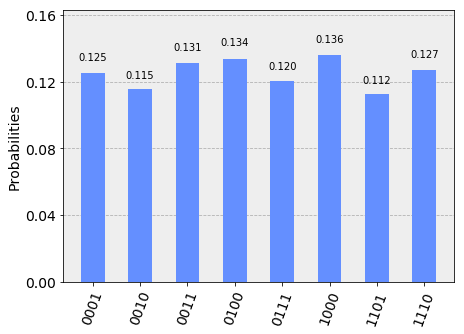

In [3]:
cr = ClassicalRegister(4)
circ = QuantumCircuit(qr, cr)

for i in range(3):
    circ.h(qr[i+1])
circ.barrier()
add_clause(circ, qr, [1, 2, -3], 4)
for i in range(4):
    circ.measure(qr[i+1], cr[i])

job = execute(circ, backend=BasicAer.get_backend("qasm_simulator"))
res = job.result().get_counts()
plot_histogram(res)

One can check that the first bit is one if and only if the last ones verify the 1-Exclusive condition for the clause 
$$ x_1 \vee x_2 \vee \neg x_3 $$


Once each clause have been computed, its result being stored on a different qubit, the last step is to flip the sign of the qubits storing the variables if all the "clauses' results" qubits are True. It is achieved with what is basically a controlled-Z on all these control qubits, toward one of the variable qubits.

In [4]:
def sign_flip(circ, qr, controls):
    """
    Flips the sign of the states whose control qubits are all one
    :param circ: circuit
    :param qr: quantum registers
    :param controls: m qubits which ensure the correctness of the solution
    :return:
    """
    circ.u1(pi, qr[1])
    cnx_o(circ, qr, controls, qr[1], qr[0])
    circ.u1(pi, qr[1])
    cnx_o(circ, qr, controls, qr[1], qr[0])


After this, it is necessary to bring the checking qubits back to zero, by applying once again all the clauses.

In [5]:
def oracle_3sat(circ, qr, clauses, var_nb):
    """
    Oracle for an Exclusive 1 SAT problem
    :param circ: circuit
    :param qr: quantum registers
    :param clauses: lists of clauses (see ex_1_3SAT)
    :param var_nb: number of variables
    :return:
    """
    nb_qbits = var_nb + len(clauses) + 1

    # adds every clause operator
    for i, clause in enumerate(clauses):
        add_clause(circ, qr, clause, var_nb + i + 1)

    # list of the qubits carrying the result of the clauses
    clauses_checkers = [qr[i] for i in range(var_nb+1, nb_qbits)]
    
    # flips the sign
    sign_flip(circ, qr, clauses_checkers)

    # removes the effect of every clause, by just applying them again
    for i, clause in enumerate(clauses):
        add_clause(circ, qr, clause, var_nb + i + 1)

Then one can apply Grover's flip around the mean, and do the whole process all over again as many times as necessary (optimally, $\frac{\pi}{4} \sqrt{2^n}$)

{'000': 4, '100': 8, '101': 973, '010': 11, '111': 7, '001': 7, '011': 7, '110': 7}


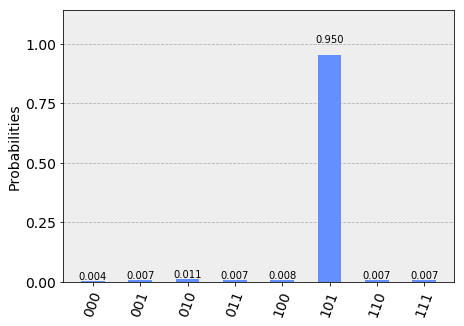

In [6]:
def grover_flip(circ, qr, to_flip):
    """
    Flip the amplitudes around the mean
    :param circ: circuit
    :param qr: quantum registers
    :param to_flip: list of the registers carrying the values of the variables
    :return:
    """
    for qr_i in to_flip:
        circ.h(qr_i)
        circ.x(qr_i)
    circ.h(to_flip[0])
    cnx_o(circ, qr, to_flip[1:], to_flip[0], qr[0])
    circ.h(to_flip[0])
    for qr_i in to_flip:
        circ.x(qr_i)
        circ.h(qr_i)

def ex_1_3sat_circuit(var_nb, clauses, nb_grover=-1):
    """
    Builds the circuit associated with the SAT problem
    :param var_nb: number of variables
    :param clauses: list of the clauses
    :param nb_grover: number of applications of grover's operator
    :return: the circuit object, and the quantum registers
    """
    nb_qbits = var_nb + len(clauses) + 1
    qr = QuantumRegister(nb_qbits)
    cr = ClassicalRegister(var_nb)
    # convention : 0: lost, 1-var_nb : variables; var_nb+1-nb_qubits : clause results;
    circ = QuantumCircuit(qr, cr)

    # superposition of the states of the variables
    for i in range(1, var_nb + 1):
        circ.h(qr[i])

    if nb_grover < 0: 
        # this is the theoretical optimal number of iterations
        # although, in practical cases, it can be preferable to iterate on a lesser number so the program is shorter
        nb_grover = ceil(sqrt(var_nb)*pi/4)

    for _ in range(nb_grover):
        oracle_3sat(circ, qr, clauses, var_nb)
        grover_flip(circ, qr, [qr[i] for i in range(1, var_nb + 1)])

    # mesure the variables at the end
    for i in range(var_nb):
        circ.measure(qr[i+1], cr[i])

    return circ, qr

def ex_1_3sat(var_nb, clauses, backend=None):
    """
    Using Grover's algorithm, exhibit the solution of an Exclusive-1 SAT problem
    :param var_nb: number of variables in the problem
    :param clauses: list of clauses
    (themselves lists of numbers, indicating the variables used in the clause with their index starting from 1,
    being negative numbers if the variable is NOTed )
    :param backend: backend to use to run the algorithm.
    :return:
    """
    circ, _ = ex_1_3sat_circuit(var_nb, clauses)
    
    if backend is None:
        backend = BasicAer.get_backend("qasm_simulator")
    
    job = execute(circ, backend=backend, shots=1024, max_credits=3)
    res = job.result().get_counts()
    #res = launch(circ, backend_type=backend, verbose=True, shots=10000)
    print(res)
    return res

# the instance presented at the beginning
res = ex_1_3sat(3, [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]])
plot_histogram(res)

The previous example exhibits the result expected with very high probability on simulator. However, on the real devices, the circuit is too long to be executed, and results are almost random (to shorten the circuit, it is possible to iterate only once. According to the simulator, the results yield are mostly the same as with the optimal number of iterations, but the circuit is much shorter, but still too long).

Note : the results are inverted with regards with the variables, ie the output states are $x_n x_{n-1} ... x_1$

#### Card finding problem

As a toy example, we want to find the card which satisfy a serie of clause conditions, in the fashion of the 1-Exclusive SAT problem.

We have a set of 32 cards, whose colors are spade, club, diamond and heart. As in the belote game, these cards are 7, 8, 9, 10, J, Q, K, A. Since we want to find a way to describe these cards with (simple) logical operators, we decide of additionnal properties to caracterize them. First, the parity of the card, starting with the 7 (odd) up to the ace (even). And second, the value of the card if it was a trump suit card (which, in belote, can be separated between low values (7, 8, Q, K) and high values (10, A, 9, J)). It can seem far-stretched (because it is), but this facilitates the mapping, making explanations clearer. 

We thus have a way to describe any card with boolean caracteristics:
* $x_1$: is the card black ?
* $x_2$: is it either a club or a heart ? (depending on $x_1$)
* $x_3$: is its symbol a letter ? (ie J, Q, K, A)
* $x_4$: is its value high ? (ie 10, A, 9, J)
* $x_5$: is it odd ?

If we take as an example the 9 of spade, it will be encoded with $x_1 = 1$ (black), $x_2 = 0$ (spade), $x_3 = 0$ (9), $x_4 = 1$ (high value) and $x_5 = 1$ (odd), thus $10011$.

In [7]:
def condition_mapping(clauses):
    conditions = ["black", "either a club or a heart", "a letter", "of high value", "even", 
                  "odd", "of low value", "a number", "either a spade or a diamond", "red"]

    
    text = "We are looking for a card which is:\n"
    
    for clause in clauses:
        text += "- "
        for val in clause:
            if val > 0:
                val -= 1
            text += conditions[val]
            text += ", or "
        text = text[:-5]
        text += ";\n And \n"
    return text[:-7]

def convert_to_card(val):
    color = int(val[:2], 2)
    sign = int(val[2:], 2)
    
    colors = ["diamonds", "hearts", "spades", "clubs"]
    signs = ["8", "7", "10", "9", "Queen", "King", "Ace", "Jack"]
    
    return signs[sign] + " of " + colors[color]
    

clauses = [[1, 2, -3], [-1, -2, -3], [-1, 2, 4], [2, 3, -5], [-1, 3, -4]]

As an example, consider the following instance :

$$
(x_1 \vee x_2 \vee \neg x_3) 
\wedge ( \neg x_1 \vee \neg x_2 \vee \neg x_3 )
\wedge ( \neg x_1 \vee x_2 \vee x_4 )
\wedge ( x_2 \vee x_3 \vee \neg x_5 )
\wedge ( \neg x_1 \vee x_3 \vee \neg x_4 )
$$

which we can now read as

In [8]:
print(condition_mapping(clauses))

We are looking for a card which is:
- black, or either a club or a heart, or a number;
 And 
- red, or either a spade or a diamond, or a number;
 And 
- red, or either a club or a heart, or of high value;
 And 
- either a club or a heart, or a letter, or odd;
 And 
- red, or a letter, or of low value;


If we now pass this to the Grover algorithm, it should give us the card satisfying this problem:

{'01101': 17, '01010': 18, '01011': 11, '00010': 9, '00110': 17, '11011': 19, '10001': 11, '01100': 17, '11110': 15, '00101': 18, '00001': 13, '10101': 12, '10010': 13, '10000': 19, '00000': 16, '11100': 12, '11010': 10, '01001': 20, '00111': 8, '11101': 597, '11000': 11, '10011': 17, '11111': 11, '01111': 16, '11001': 15, '10111': 8, '01000': 12, '00100': 9, '01110': 9, '00011': 17, '10100': 16, '10110': 11}
The answer is the Jack of spades


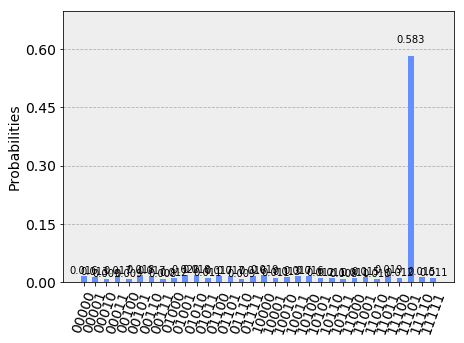

In [9]:
res = ex_1_3sat(5, clauses)
sol = max(res, key=lambda x: res[x])
sol = sol[::-1]
# answers are given in reverse order with regard to general convention
print("The answer is the " + convert_to_card(sol))
plot_histogram(res)


#### Appendix

This is a quick proof of the correctness of the design of the clause operator. What we need to prove is that an odd number of NOT gates is applied to the target qubit if and only if exactly one of the variable in the clause is True, and thus that this qubit is set to 1 only in this case.

Let $l$ be the number of variables set to True, ie the number of qubits whose value after the X gates is one (of course, we are speaking in terms of pure states, but it works similarly for superposed states, as usual), $p$ the number of variables in the clause (3 in a 3SAT problem).

Then, for the sequence of $(2i+1)$qubits-Controlled-NOT (every possibility over the $p$ qubits), there will be ${l \choose {2i+1}}$ NOT applied to the target qubit.

Thus, if $l=2r + 1$, the total number of NOT applied will be

$$ \sum_{i=0}^r {{2r+1} \choose {2i+1}} = \sum_{i=0}^r {{2r+1} \choose {i}} = \frac{1}{2}\sum_{i=0}^{2r+1} {{2r+1} \choose {i}} = 2^{2r}$$

which is even, except if $r = 0$, ie $l = 1$.

If $l = 2r$, we have

$$ \sum_{i=0}^r {{2r} \choose {2i+1}} = \sum_{i=0}^{r/2 - 1} {{2r+1} \choose {2i+1}} + \sum_{i=r/2 + 1}^r {{2r+1} \choose {2i+1}} + \alpha_r = 2\sum_{i=0}^{r/2 - 1} {{2r+1} \choose {2i+1}} + \alpha_r$$

with $\alpha_r = {{2r} \choose r}$ if $r$ is even, $0$ if it is odd. Yet $ \alpha_r = {{2r} \choose r} = {{2r - 1} \choose r} + {{2r - 1} \choose {r - 1}} = 2{{2r-1} \choose r}$ is even. Thus, in every case, the number of NOT will be even if $l$ is even.

Thus this clause operator will behave as expected. 